# Visualizing a representation of the `penguins` dataset in 2D with *Self-Organizing Map*

In [01_kmeans_clustering.ipynb](./01_kmeans_clustering.ipynb) we use/used the `K-Means` algorithm to find groups of data points. Here, we want to learn a representation of the dataset. K-Means may also be used for representation learning in a sense that it discretizes the data space into disjoint regions. However, once we have a dataset that has more than three dimensions, visualizing these groups becomes challenging.

On the other hand, a *Self-Organizing Map* is similar to `K-Means` in a sense that it also operates with centroids to which data samples get mapped, yet one very important difference here is that the centroids are chained together from the very beginning so after it discovers and maps the dataset, the neighboring information can be used to flatten the SOM grid into a 2D visual. As hinted, SOM itself could be used for clustering as well, and in this notebook the objective is to learn and visualize the simpler representation of the original dataset along with clustering the data points.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAND = 42

## Dataset

In [2]:
X_scaled = pd.read_csv("../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
X_scaled_idx = X_scaled.index
X_scaled = X_scaled.to_numpy()
y = pd.read_csv("../datasets/penguins/simple/y.csv", index_col=0, header=0)

## Representation learning

In [3]:
from _utilities.som import calc_recommended_grid_size, train_som
from _utilities.som_plot import visualize_distance_map, visualize_hitmap, plot_3_feature, plot_in_3PC

In [4]:
print("Recommended grid size:", calc_recommended_grid_size(X_scaled))

Recommended grid size: (np.float64(92.46621004453465), 10)


In [5]:
SOM_DIM = 32 # increasing from recommendation for more detailed map
SOM_SIGMA = np.round(SOM_DIM / 3)
SOM_NUM_ITERATION = 25
SOM_LEARNING_RATE = .6

hyparams = {
    "d1": SOM_DIM,
    "d2": SOM_DIM,
    "sigma": SOM_SIGMA,
    "learning_rate": .5,
    "num_iteration": SOM_NUM_ITERATION,
    "topology": "rectangular"
}

som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=True)

node_weights = som.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])
activation_map = som.activation_response(X_scaled)
activations_flat = activation_map.flatten()

 [ 8550 / 8550 ] 100% - 0:00:00 left 
 quantization error: 0.4389628685983146

Brief quality of SOM:
Quantization error:	0.439
Topographic error:	0.003
Topographic error (VN):	0.067


In [6]:
# PCA

from sklearn.decomposition import PCA

pca = PCA().fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)
node_weights_flat_pca = pca.transform(node_weights_flat)

print("PCA features explained variance:", np.round((pca.explained_variance_ / pca.explained_variance_.sum()), 3))

PCA features explained variance: [0.688 0.193 0.091 0.027]


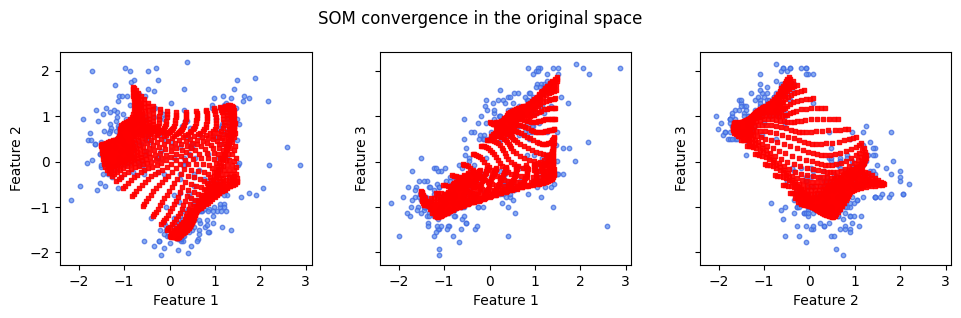

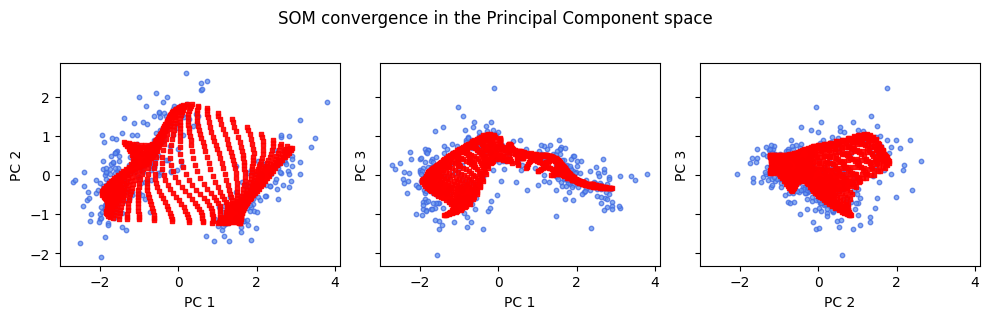

In [7]:
plot_3_feature(X_scaled, node_weights_flat, axis_label="Feature", figsize=(10, 3), title="SOM convergence in the original space")
plot_3_feature(X_scaled_pca, node_weights_flat_pca, axis_label="PC", figsize=(10, 3), title="SOM convergence in the Principal Component space")

In [8]:
plot_in_3PC(X_scaled_pca, nw_shape=node_weights.shape, nw_flat=node_weights_flat_pca)

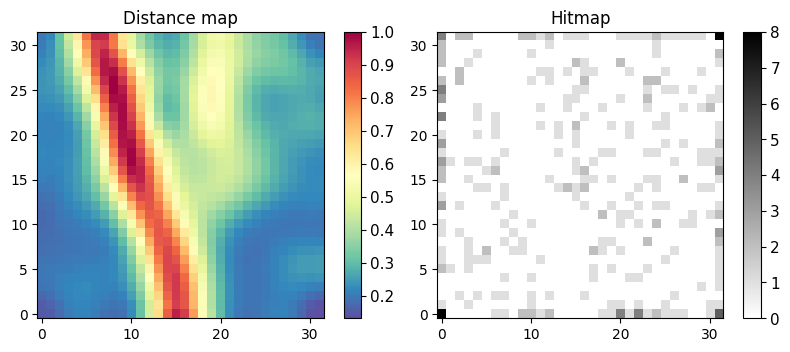

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

plt.tight_layout()         
plt.show()

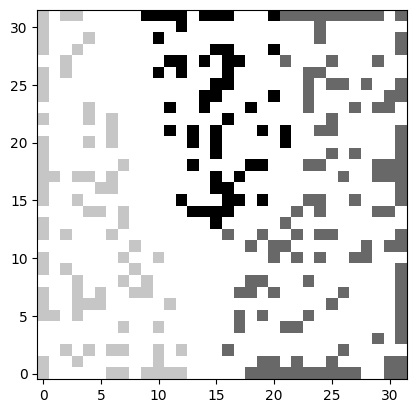

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="average").fit(node_weights_flat)

clustering_map = clustering.labels_.reshape(activation_map.shape)
clustering_map[activation_map == 0] = -1

plt.imshow(clustering.labels_.reshape(activation_map.shape), origin="lower", cmap="Greys")

y_pred = np.array([clustering_map[som.winner(x)] for x in X_scaled])

In [11]:
# export clustering predictions
df_pred = pd.DataFrame(y_pred, index=X_scaled_idx, columns=['cluster_id'])
df_pred.to_csv("02_som_representation_learning_Matthew.csv")